* ~~Generate weight matrix + cov_a & send to Bruno as a mat file~~

* ~~Redo run with more images to get better convergence & estimate of a_cov~~
  * ~~need to fix memory leak?~~

* ~~Plot eigenvectors of cov_a in addition to pooling weights~~

* ~~Create summary plot for cov_a~~

* ~~rerun everything with ICA vs LCA~~

* Aapo does not subsample
  * If you reduce to K dimensions, then you technically should only need K pooling filters
  * How to space them evenly?

* Rewrite pooling as a 3-term energy function, write LCA to get feedback from pooling layer
  * could also get feedback from eigenvectors
 
* Once you have a 2-layer network, you should be able to compress or denoise an image

* Write up that discussess all pooling methods in one framework? I've started this...

* ~~For get_dictionary_stats: Should use center of mass of envelope, instead of max pixel value.~~
  * ~~Upsample fft / ifft for finding a better center~~
  * ~~This prevents issues with aliasing. You're limited to 16x16px resolution, but the true center of the BF could be between pixels.~~
  *~~ Convolving with Laplacian will make it slightly more peaky, but will not solve the aliasing problem.~~
  * ~~Possible methods could be fitting Gaussian, computing convex hull, computing blob boundaries.~~
  *~~ Add zero padding option to hilbertize~~
    * ~~Can zero-pad in space domain to get interpolated fft~~
    * ~~can zero-pad (e.g. 16x16 -> 64x64) in fft domain, then ifft, to get interpolated space image~~
    * ~~once you get centers, multiply by e.g. 64/16~~ (should be 16/64?)
  * ~~Finding centers~~
    * ~~center of mass of (upsampled?) thresholded image~~
    * ~~fit a gaussian~~
  
* ~~For a given row in covariance matrix, plot that BF, then plot the BF corresponding to the top N indices in the row. These should be visually similar to the row's BF.~~

* ~~Fix contrast normalizing steps~~
  * ~~can LPF the raw image, then use that as denominator in normalization~~
  * ~~this way it is positive only values~~
  * ~~vanilla division would be Image / std(image) as a first step - subtract mean, divide by variance, whiten~~
  * ~~Look at charles' document~~

* ~~Don't use np.cov - use dot(a_vals.T, a_vals)~~

* Fix up orientation computation in fourier domain
  * Possibly do pi - angle 
  
* Padding messes up stats -> fix up bf_stats to incl more info and rescale objects to pre-padded values
  * pad out FFT to 32x32 instead of smoothing - causes new edge artifacts in Hilbert analysis???
  * Verify rescaling for finding centers - when you IFFT your dim are the padded size right?
  
* ~~Sort a_evals before plotting~~

* Get line plots working, make ellipse plots look interpretable
  * set ellipse alpha to spatial freq?


## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import os                                                                       
import numpy as np                                                              
import tensorflow as tf                                                         
import data.data_picker as dp                                                   
import utils.plot_functions as pf                                               
import utils.image_processing as ip                                             

## Model parameters

In [3]:
params = {                                                                      
  ## Model params                                                               
  "out_dir": os.path.expanduser("~")+"/Work/Projects/test/outputs/",       
  "chk_dir": os.path.expanduser("~")+"/Work/Projects/test/checkpoints/",
  "data_dir": os.path.expanduser("~")+"/Work/Datasets/",
  "load_chk": True,                                                             
  "load_cov": True,
  "update_interval": 1000,                                                       
  "device": "/gpu:0",                                                           
  "learning_rate": 0.12,                                                        
  "num_neurons": 500,                                                           
  "sparse_mult": 0.2,                                                           
  "num_inference_steps": 20,                                                    
  "eta": 0.001/0.03, #dt/tau                                                    
  "eps": 1e-12,                                                                 
  ## Data params                                                                
  "data_type": "vanhateren",                                                    
  "rand_state": np.random.RandomState(12345),                                   
  "num_images": 100,                                                          
  "num_batches": int(1e5), #Total dataset size is num_batches*batch_size
  "batch_size": 100,                                                            
  "patch_edge_size": 16,                                                        
  "overlapping_patches": True,                                                  
  "patch_variance_threshold": 1e-6,                                             
  "conv": False,                                                                
  "whiten_images": True,
  "contrast_normalize": False,
  ## Fourier analysis params
  "ft_padding": 20,
  ## Pooling params
  "cov_num_images":int(1e7),
  "num_pooling_dims": 50, #K
  ## Visualization params
  "num_pooling_filters":50,
  "num_connected_weights":250}

## Calculated params                                                            
params["epoch_size"] = params["batch_size"] * params["num_batches"]             
params["num_pixels"] = int(params["patch_edge_size"]**2)                        
params["dataset_shape"] = [int(val)                                             
    for val in [params["epoch_size"], params["num_pixels"]]],                   
params["phi_shape"] = [params["num_pixels"], params["num_neurons"]]             

## Functions for analysis

### Pooling filters function

In [4]:
def compute_pooling_filters(activity_covariance, num_pooling_dims):
  evals, evecs = np.linalg.eig(activity_covariance)
  sort_indices = np.argsort(evals)[::-1]
  top_vecs = evecs[sort_indices[:num_pooling_dims]]
  pooling_filters = np.dot(top_vecs.T, top_vecs)
  return pooling_filters

## Load dataset

In [5]:
if not params["load_cov"] or not params["load_chk"]: 
  data = dp.get_data(params["data_type"], params)                                 
  params["input_shape"] = [                                                       
    data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     

## Define graph

In [6]:
graph = tf.Graph()
with tf.device(params["device"]):
  with graph.as_default():
    with tf.name_scope("placeholders") as scope:
      x = tf.placeholder(tf.float32, shape=[None, params["num_pixels"]],
        name="input_data")
      sparse_mult = tf.placeholder(tf.float32, shape=(), name="sparse_mult")

    with tf.name_scope("constants") as scope:
      u_zeros = tf.zeros(shape=tf.stack([tf.shape(x)[0], params["num_neurons"]]),
        dtype=tf.float32, name="u_zeros")

    with tf.name_scope("step_counter") as scope:
      global_step = tf.Variable(0, trainable=False, name="global_step")

    with tf.variable_scope("weights") as scope:
      phi_init = tf.truncated_normal(params["phi_shape"], mean=0.0, stddev=0.2,
        dtype=tf.float32, name="phi_init")
      phi = tf.get_variable(name="phi", dtype=tf.float32,
        initializer=phi_init, trainable=True)

    with tf.name_scope("norm_weights") as scope:
      norm_phi = phi.assign(tf.nn.l2_normalize(phi,
        dim=0, epsilon=params["eps"], name="row_l2_norm"))
      norm_weights = tf.group(norm_phi,
        name="l2_normalization")

    with tf.name_scope("inference") as scope:
      u = tf.Variable(u_zeros, trainable=False,
        validate_shape=False, name="u")
      # soft thresholded, rectified
      a = tf.where(tf.greater(u, sparse_mult),
        tf.subtract(u, sparse_mult), u_zeros,
        name="activity")
      a_cov = tf.divide(tf.matmul(tf.transpose(a), a, name="a_cov_matrix"),
        tf.to_float(tf.shape(x)[0]))

    with tf.name_scope("output") as scope:
      with tf.name_scope("image_estimate"):
        x_ = tf.matmul(a, tf.transpose(phi),
          name="reconstruction")

    with tf.name_scope("loss") as scope:
      with tf.name_scope("unsupervised"):
        recon_loss = tf.reduce_mean(0.5 *
          tf.reduce_sum(tf.pow(tf.subtract(x, x_), 2.0),
          axis=[1]), name="recon_loss")
        sparse_loss = sparse_mult * tf.reduce_mean(
          tf.reduce_sum(tf.abs(a), axis=[1]),
          name="sparse_loss")
        unsupervised_loss = (recon_loss + sparse_loss)
      total_loss = unsupervised_loss

    with tf.name_scope("update_u") as scope:
      lca_b = tf.matmul(x, phi, name="driving_input")
      lca_g = (tf.matmul(tf.transpose(phi), phi,
        name="gram_matrix") -
        tf.constant(np.identity(params["phi_shape"][1], dtype=np.float32),
        name="identity_matrix"))
      lca_explain_away = tf.matmul(a, lca_g,
        name="explaining_away")
      du = lca_b - lca_explain_away - u
      step_inference = tf.group(u.assign_add(params["eta"] * du),
        name="step_inference")
      reset_activity = tf.group(u.assign(u_zeros),
        name="reset_activity")

    with tf.name_scope("performance_metrics") as scope:
      with tf.name_scope("reconstruction_quality"):
        MSE = tf.reduce_mean(tf.pow(tf.subtract(x, x_), 2.0),
          axis=[1, 0], name="mean_squared_error")

    with tf.name_scope("optimizers") as scope:
      learning_rates = tf.train.exponential_decay(
        learning_rate=params["learning_rate"],
        global_step=global_step,
        decay_steps=int(np.floor(params["num_batches"]*0.8)),
        decay_rate=0.5,
        staircase=True,
        name="phi_annealing_schedule")
      optimizer = tf.train.GradientDescentOptimizer(learning_rates,
        name="phi_optimizer")
      update_weights = optimizer.minimize(total_loss, global_step=global_step,
        var_list=[phi], name="phi_minimizer")

    full_saver = tf.train.Saver(var_list=[phi], max_to_keep=2)

    with tf.name_scope("summaries") as scope:
      #tf.summary.image("input", tf.reshape(x, [params["batch_size"],
      #  params["patch_edge_size"], params["patch_edge_size"], 1]))
      #tf.summary.image("weights", tf.reshape(tf.transpose(phi),
      #  [params["num_neurons"], params["patch_edge_size"],
      #  params["patch_edge_size"], 1]))
      tf.summary.histogram("u", u)
      tf.summary.histogram("a", a)
      tf.summary.histogram("phi", phi)

    merged_summaries = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(params["out_dir"], graph)

    with tf.name_scope("initialization") as scope:
      init_op = tf.group(tf.global_variables_initializer(),
        tf.local_variables_initializer())

## Train LCA model (if needed)

In [7]:
if not params["load_chk"]:
  if not os.path.exists(params["out_dir"]):
    os.makedirs(params["out_dir"])
  if not os.path.exists(params["chk_dir"]):
    os.makedirs(params["chk_dir"])

  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
    feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    
    sess.graph.finalize() # Graph is read-only after this statement.

    num_updates = np.int32(np.floor(params["num_batches"]/params["update_interval"]))
    batch_steps = [None]*num_updates
    losses = [None]*num_updates
    sparsities = [None]*num_updates
    recon_errors = [None]*num_updates
    update_idx = 0
    for b_step in range(params["num_batches"]):
      input_data = data["train"].next_batch(params["batch_size"])[0]
    
      feed_dict = {x:input_data, sparse_mult:params["sparse_mult"]}

      sess.run(norm_weights, feed_dict)

      for inference_step in range(params["num_inference_steps"]):               
        sess.run(step_inference, feed_dict)

      sess.run(update_weights, feed_dict)

      current_step = sess.run(global_step)
      if (current_step % params["update_interval"] == 0):
        summary = sess.run(merged_summaries, feed_dict)
        train_writer.add_summary(summary, current_step)
        full_saver.save(sess, save_path=params["chk_dir"]+"lca_chk",
          global_step=global_step)
        [current_loss, a_vals, recons, recon_err, weights] = sess.run(
          [total_loss, a, x_, MSE, phi], feed_dict)
        
        a_vals_max = np.array(a_vals.max()).tolist()
        a_frac_act = np.array(np.count_nonzero(a_vals)
          / float(params["batch_size"]*params["num_neurons"])).tolist()
        batch_steps[update_idx] = current_step
        losses[update_idx] = current_loss
        sparsities[update_idx] = a_frac_act
        recon_errors[update_idx] = recon_err

        print_dict = {"current_step":str(current_step).zfill(5),
          "loss":str(current_loss),
          "a_max":str(a_vals_max),
          "a_frac_act":str(a_frac_act),
          "recon_err":str(recon_err)}
        print(print_dict)
        pf.save_data_tiled(weights.T.reshape((params["num_neurons"],
          params["patch_edge_size"], params["patch_edge_size"])),
          normalize=False, title="Dictionary at step "+str(current_step),
          save_filename=(params["out_dir"]+"phi_"+str(current_step).zfill(5)
          +".png"))
        pf.save_data_tiled(recons.reshape((params["batch_size"],
          params["patch_edge_size"], params["patch_edge_size"])),
          normalize=False, title="Recons at step "+str(current_step),
          save_filename=(params["out_dir"]+"recons_"
          +str(current_step).zfill(5)+".png"))
        update_idx += 1
    output_data = {"batch_step":batch_steps, "total_loss":losses,
      "frac_active":sparsities, "recon_MSE":recon_errors}
    pf.save_stats(output_data,
      save_filename=(params["out_dir"]+"train_stats.png"))

## Compute activity covariance & pooling filters

### Compute activity covariance matrix

In [8]:
def log_progress(sequence, every=None, size=None, name='Items'):
  from ipywidgets import IntProgress, HTML, VBox
  from IPython.display import display
  is_iterator = False
  if size is None:
    try:
      size = len(sequence)
    except TypeError:
      is_iterator = True
  if size is not None:
    if every is None:
      if size <= 200:
        every = 1
      else:
        every = int(size / 200)     # every 0.5%
  else:
    assert every is not None, 'sequence is iterator, set every'
  if is_iterator:
    progress = IntProgress(min=0, max=1, value=1)
    progress.bar_style = 'info'
  else:
    progress = IntProgress(min=0, max=size, value=0)
  label = HTML()
  box = VBox(children=[label, progress])
  display(box)
  index = 0
  try:
    for index, record in enumerate(sequence, 1):
      if index == 1 or index % every == 0:
        if is_iterator:
          label.value = '{name}: {index} / ?'.format(
            name=name,
            index=index
          )
        else:
          progress.value = index
          label.value = u'{name}: {index} / {size}'.format(
            name=name,
            index=index,
            size=size
          )
      yield record
  except:
    progress.bar_style = 'danger'
    raise
  else:
    progress.bar_style = 'success'
    progress.value = index
    label.value = "{name}: {index}".format(
      name=name,
      index=str(index or '?')
    )

In [9]:
if params["load_cov"]:
  act_cov = np.load(params["out_dir"]+"act_cov.npz")["data"]
  weights = np.load(params["out_dir"]+"weights.npz")["data"]
else:
  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
      feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    full_saver.restore(sess, tf.train.latest_checkpoint(params["chk_dir"]))
    weights = sess.run(phi)
    act_cov = None
    num_cov_in_avg = 0
    tot_images = 0
    for tot_images in log_parser(range(0, params["cov_num_images"], params["batch_size"]), every=1):
      input_data = data["train"].next_batch(params["batch_size"])[0]
      feed_dict = {x:input_data, sparse_mult:params["sparse_mult"]}
      for inference_step in range(params["num_inference_steps"]):               
        sess.run(step_inference, feed_dict)
      if act_cov is None:
        act_cov = sess.run(a_cov, feed_dict)
      else:
        act_cov += sess.run(a_cov, feed_dict)
      num_cov_in_avg += 1
    act_cov /= num_cov_in_avg
  np.savez(params["out_dir"]+"act_cov.npz", data=act_cov)
  np.savez(params["out_dir"]+"weights.npz", data=weights)
#import scipy.io as sio
#sio.savemat(params["out_dir"]+"phi_weights.mat", {"weights":weights})
#sio.savemat(params["out_dir"]+"act_cov.mat", {"act_cov":act_cov})
a_evals, a_evecs = np.linalg.eig(act_cov)
a_sort_indices = np.argsort(a_evals)[::-1]

### Compute pooling filters

In [10]:
pooling_filters = compute_pooling_filters(act_cov, params["num_pooling_dims"])

In [11]:
bf_stats = ip.get_dictionary_stats(weights, 20)

## Construct analysis plots

### Activity covariance matrix summaries

#### Activity covariance matrix

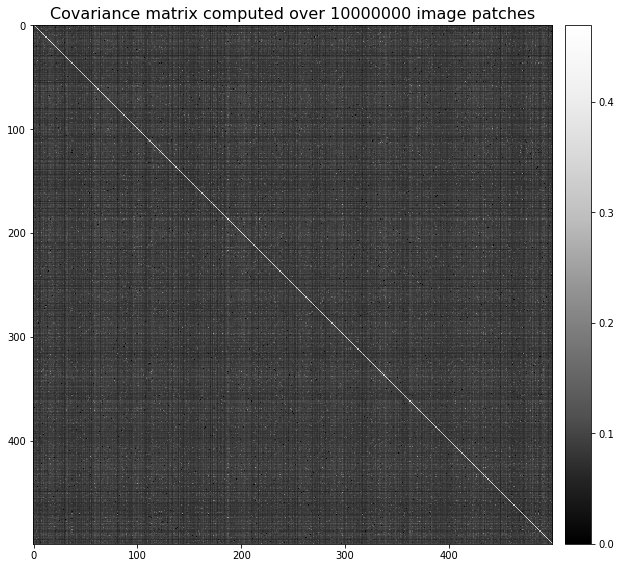

In [12]:
fig, ax = plt.subplots(1, figsize=(10,10))
im = ax.imshow(act_cov, cmap="Greys_r", interpolation="nearest")
im.set_clim(vmin=0, vmax=np.max(act_cov))
ax.set_title("Covariance matrix computed over "+str(params["cov_num_images"])+" image patches", fontsize=16)
pf.add_colorbar(im)
plt.show()

#### Eigenvalues of the activity covariance matrix

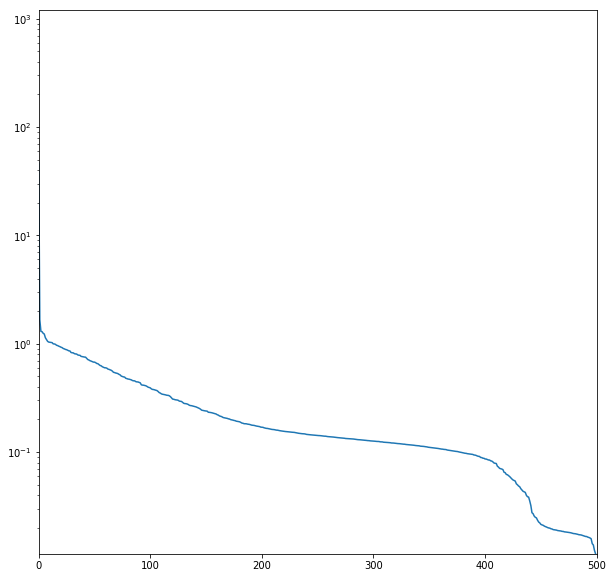

In [13]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.semilogy(a_evals[a_sort_indices])
ax.set_xlim(0, 500) # Ignore first eigenvalue
ax.set_ylim(0, 1200)
ax.set_yscale("log")
plt.show()

#### Top connected basis functions

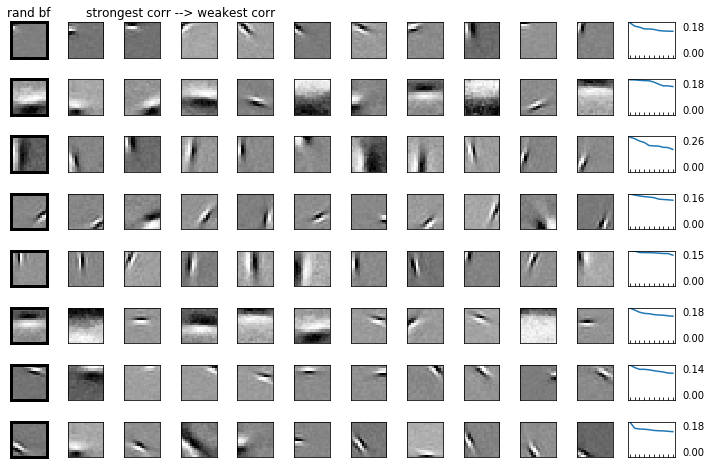

In [14]:
num_random_bases = 8
num_top_cov_bases = 10
bf_indices = np.random.choice(np.arange(act_cov.shape[0]), num_random_bases)
pf.plot_top_bases(act_cov, weights, bf_indices, num_top_cov_bases)

### Basis function analysis

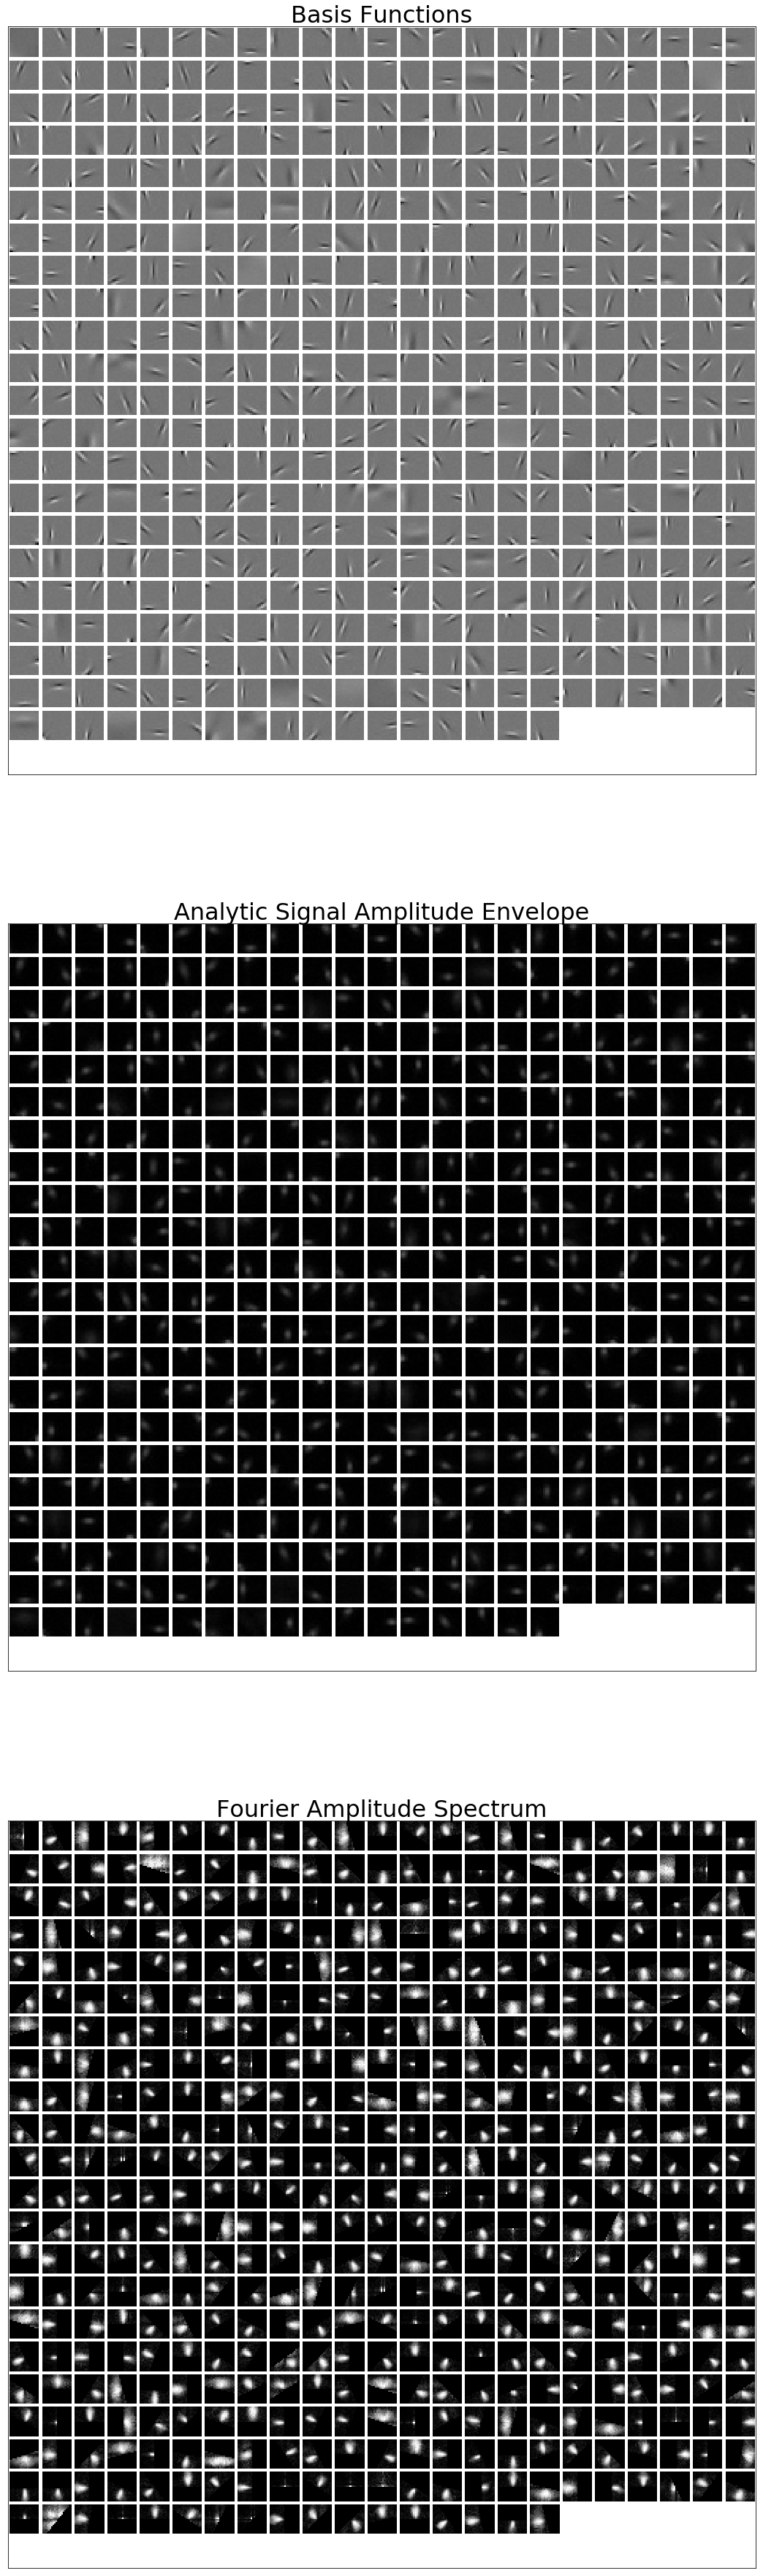

In [15]:
pf.plot_hilbert_analysis(weights, params["ft_padding"])

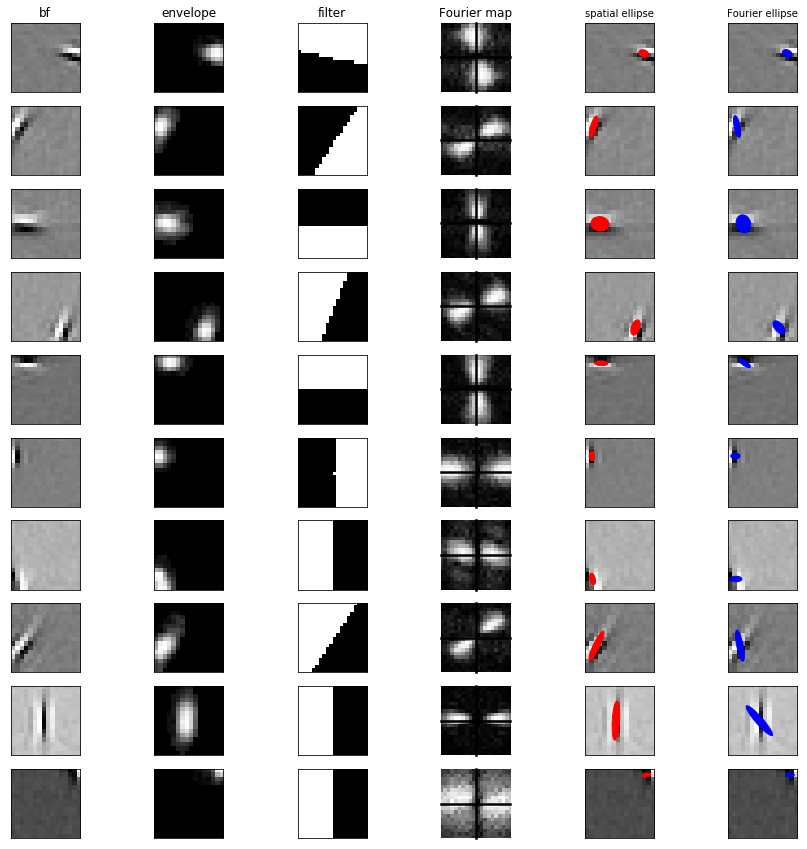

In [16]:
num_bf = 10
pf.plot_bf_stats(bf_stats, num_bf)

### Pooling and eigen summary plots

In [57]:
def plot_gaussian_contours(bf_stats, num_plots):
  num_bf = bf_stats["num_outputs"]
  bf_range = np.random.choice([i for i in range(num_bf)], num_plots)
  num_plots_y = int(np.ceil(np.sqrt(num_plots)))
  num_plots_x = int(np.floor(np.sqrt(num_plots)))
  fig, sub_ax = plt.subplots(num_plots_y, num_plots_x, figsize=(10,10))
  filter_total = 0
  for plot_idx in  np.ndindex((num_plots_y, num_plots_x)):
    if filter_total < num_plots:
      bf_idx = bf_range[filter_total]
      envelope = bf_stats["envelopes"][bf_idx]
      center = bf_stats["envelope_centers"][bf_idx]
      (gauss_fit, grid) = bf_stats["gauss_fits"][bf_idx]
      contour_levels = 3
      sub_ax[plot_idx].imshow(envelope, cmap="Greys_r", extent=(0, 16, 16, 0))
      sub_ax[plot_idx].contour(grid[1], grid[0], gauss_fit, contour_levels, colors='b')
      sub_ax[plot_idx].plot(center[1], center[0], "ro")
      sub_ax[plot_idx].set_title("bf:"+str(bf_idx), fontsize=10)
      filter_total += 1
    sub_ax[plot_idx].spines["right"].set_color("none")
    sub_ax[plot_idx].spines["top"].set_color("none")
    sub_ax[plot_idx].spines["left"].set_color("none")
    sub_ax[plot_idx].spines["bottom"].set_color("none")
    sub_ax[plot_idx].tick_params(axis="both", bottom="off", top="off", left="off", right="off")
    sub_ax[plot_idx].get_xaxis().set_visible(False)
    sub_ax[plot_idx].get_yaxis().set_visible(False)
    sub_ax[plot_idx].set_aspect("equal")
  plt.show()

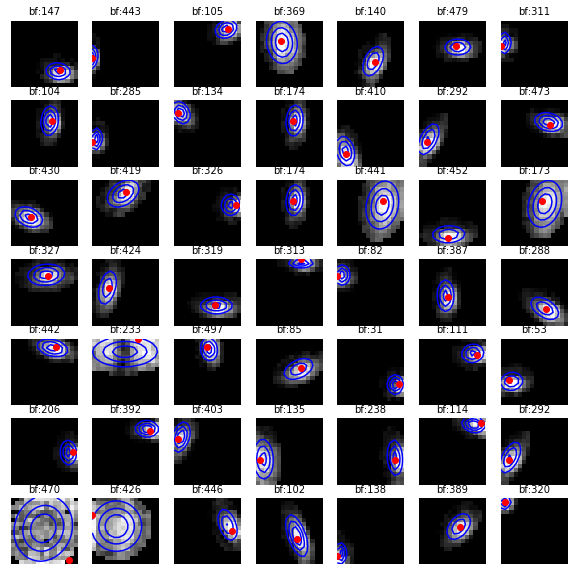

In [58]:
num_plots = 49
plot_gaussian_contours(bf_stats, num_plots)

In [19]:
def plot_ellipse(axis, center, orientation, colorVal, alpha=1.0, lines=False):
  y_cen, x_cen = center
  evals, evecs = orientation
  angle = np.rad2deg(np.arctan2(*evecs[:,0]))
  width, height = evals
  if lines:
    min_length = 0.1
    if width < height:
      width = min_length
    elif width > height:
      height = min_length
  e = matplotlib.patches.Ellipse(xy=[x_cen, y_cen], width=width,
    height=height, angle=angle, edgecolor=colorVal, facecolor=colorVal,
    alpha=alpha, fill=True)
  axis.add_artist(e)
  e.set_clip_box(axis.bbox)

In [33]:
"""
Plot outputs of the function ip.get_dictionary_stats()
Inputs:
  bf_stats [dict] output of ip.get_dictionary_stats()
  num_bf [int] number of basis functions to plot (must be >=4)
  lines [bool] If true, will plot lines instead of ellipses
"""
def plot_ellipse_summaries(bf_stats, num_bf=4, lines=False):
  tot_num_bf = len(bf_stats["basis_functions"])
  bf_range = np.random.choice([i for i in range(tot_num_bf)],
    num_bf, replace=False)
  num_plots_y = int(np.ceil(np.sqrt(num_bf)))
  num_plots_x = int(np.floor(np.sqrt(num_bf)))
  filter_idx = 0
  fig, sub_ax = plt.subplots(num_plots_y, num_plots_x, figsize=(17, 17))
  for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
    if filter_idx < tot_num_bf:
      bf = bf_stats["basis_functions"][filter_idx]
      sub_ax[plot_id].imshow(bf, interpolation="Nearest", cmap="Greys_r")
      center = bf_stats["gauss_centers"][filter_idx]
      orientation = bf_stats["orientations"][filter_idx]
      alpha = 1.0
      colorVal = "r"
      plot_ellipse(sub_ax[plot_id], center, orientation, colorVal, alpha, lines)
      sub_ax[plot_id].tick_params(axis="both", bottom="off", top="off",
        left="off", right="off")
      sub_ax[plot_id].get_xaxis().set_visible(False)
      sub_ax[plot_id].get_yaxis().set_visible(False)
      filter_idx += 1
    sub_ax[plot_id].spines["right"].set_color("none")
    sub_ax[plot_id].spines["top"].set_color("none")
    sub_ax[plot_id].spines["left"].set_color("none")
    sub_ax[plot_id].spines["bottom"].set_color("none")
    sub_ax[plot_id].tick_params(axis="both", bottom="off", top="off", left="off", right="off")
    sub_ax[plot_id].get_xaxis().set_visible(False)
    sub_ax[plot_id].get_yaxis().set_visible(False)
    sub_ax[plot_id].set_aspect("equal")
  plt.show()

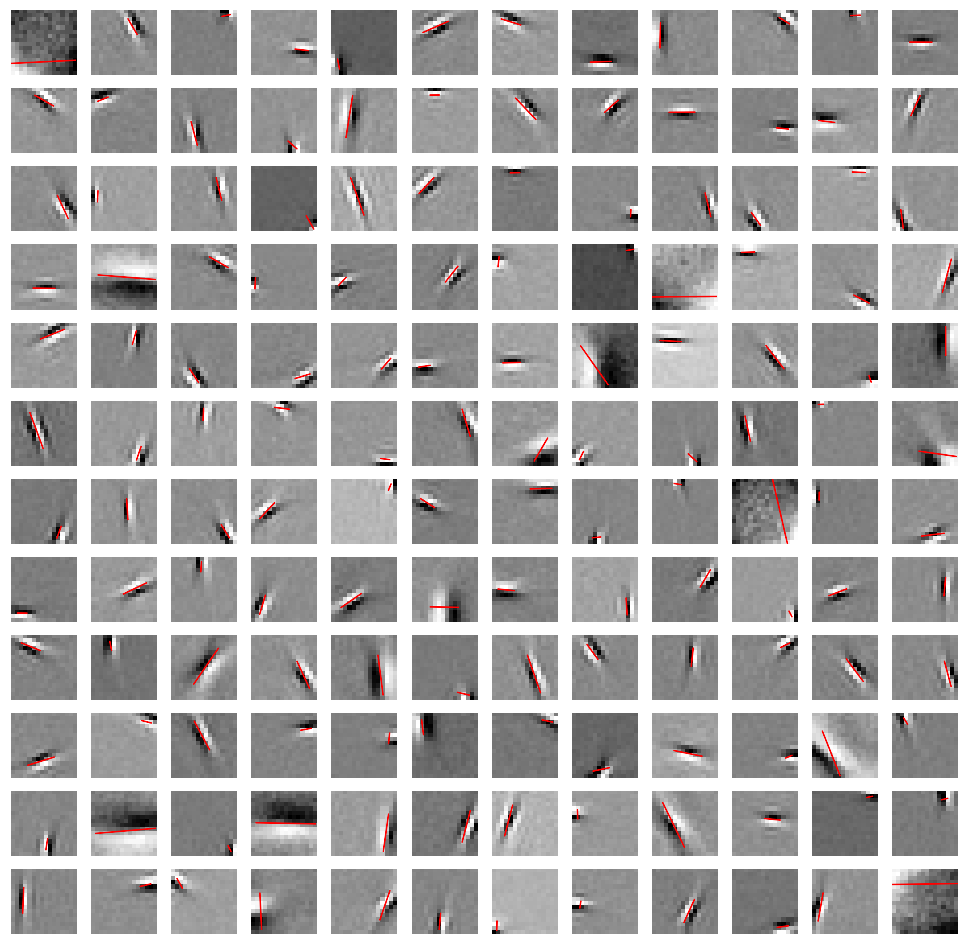

In [56]:
num_bf = 144
lines = True
plot_ellipse_summaries(bf_stats, num_bf, lines)

In [52]:
def plot_pooling_summaries(bf_stats, pooling_filters, num_connected_weights, num_pooling_filters, lines=False):
  num_inputs = bf_stats["num_inputs"]
  num_outputs = bf_stats["num_outputs"]
  patch_edge_size = np.int32(np.sqrt(num_inputs))
  assert num_pooling_filters <= num_outputs, (
    "num_pooling_filters must be less than or equal to bf_stats['num_outputs']")
  cmap = plt.get_cmap('bwr')
  cNorm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
  scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
  num_plts_y = np.int32(np.ceil(np.sqrt(num_pooling_filters)))
  num_plts_x = np.int32(np.floor(np.sqrt(num_pooling_filters)))+1 # +cbar row
  fig, sub_ax = plt.subplots(num_plts_y, num_plts_x, figsize=(15,15))
  filter_idx_list = np.random.choice(np.arange(pooling_filters.shape[0],
    dtype=np.int32), size=num_pooling_filters, replace=False)
  filter_total = 0
  for plot_id in  np.ndindex((num_plts_y, num_plts_x)):
    (y_id, x_id) = plot_id
    if (filter_total < num_pooling_filters and x_id != num_plts_x-1):
      filter_idx = filter_idx_list[filter_total]
      example_filter = pooling_filters[filter_idx, :]
      top_indices = np.argsort(np.abs(example_filter))[::-1]
      filter_norm = np.max(np.abs(example_filter))
      SFs = np.asarray([fstats[1] for fstats in bf_stats["fourier_stats"]], dtype=np.float32)
      sf_norm = np.max(SFs)
      # Plot weakest of the top connected filters first because of occlusion
      for bf_idx in top_indices[:num_connected_weights][::-1]:
        connection_strength = example_filter[bf_idx]/filter_norm
        colorVal = scalarMap.to_rgba(connection_strength)
        center = bf_stats["gauss_centers"][bf_idx]
        orientation = bf_stats["orientations"][bf_idx]
        ## TODO: Add Fourier info
        #spatial_freq = bf_stats["fourier_stats"][bf_idx][1] / sf_norm
        #angle = np.rad2deg(bf_stats["fourier_stats"][bf_idx][2])
        #alpha = spatial frequency? change alpha to "none" or exists as kwarg
        plot_ellipse(sub_ax[plot_id], center, orientation, colorVal, alpha=1.0, lines=lines)
      sub_ax[plot_id].set_xlim(0, patch_edge_size-1)
      sub_ax[plot_id].set_ylim(0, patch_edge_size-1)
      sub_ax[plot_id].set_aspect("equal")
      filter_total += 1
    else:
      sub_ax[plot_id].spines["right"].set_color("none")
      sub_ax[plot_id].spines["top"].set_color("none")
      sub_ax[plot_id].spines["left"].set_color("none")
      sub_ax[plot_id].spines["bottom"].set_color("none")
    sub_ax[plot_id].invert_yaxis()
    sub_ax[plot_id].set_yticklabels([])
    sub_ax[plot_id].set_xticklabels([])
    sub_ax[plot_id].set_aspect("equal")
    sub_ax[plot_id].tick_params(axis="both", bottom="off", top="off",
      left="off", right="off")
  scalarMap._A = []
  cbar = fig.colorbar(scalarMap, ax=list(sub_ax[:, -1]), ticks=[-1, 0, 1])
  plt.show()

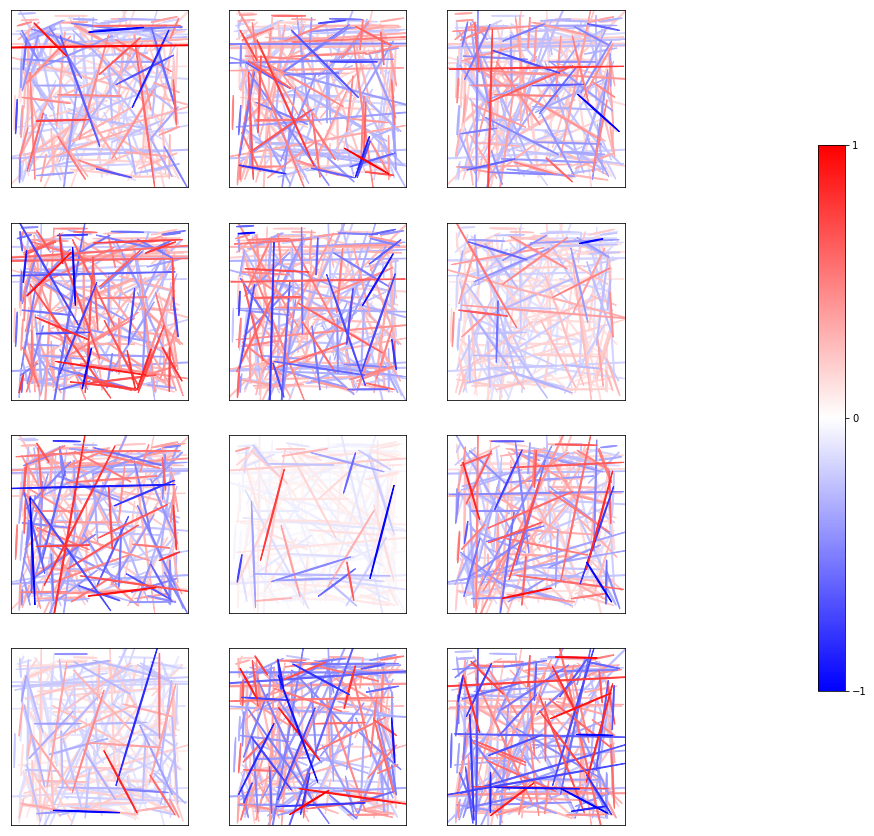

In [55]:
params["num_pooling_filters"] = 12
params["num_connected_weights"] = 250#75
lines = True
plot_pooling_summaries(bf_stats, a_evecs[a_sort_indices[:params["num_pooling_filters"]]],
  params["num_connected_weights"], params["num_pooling_filters"], lines)

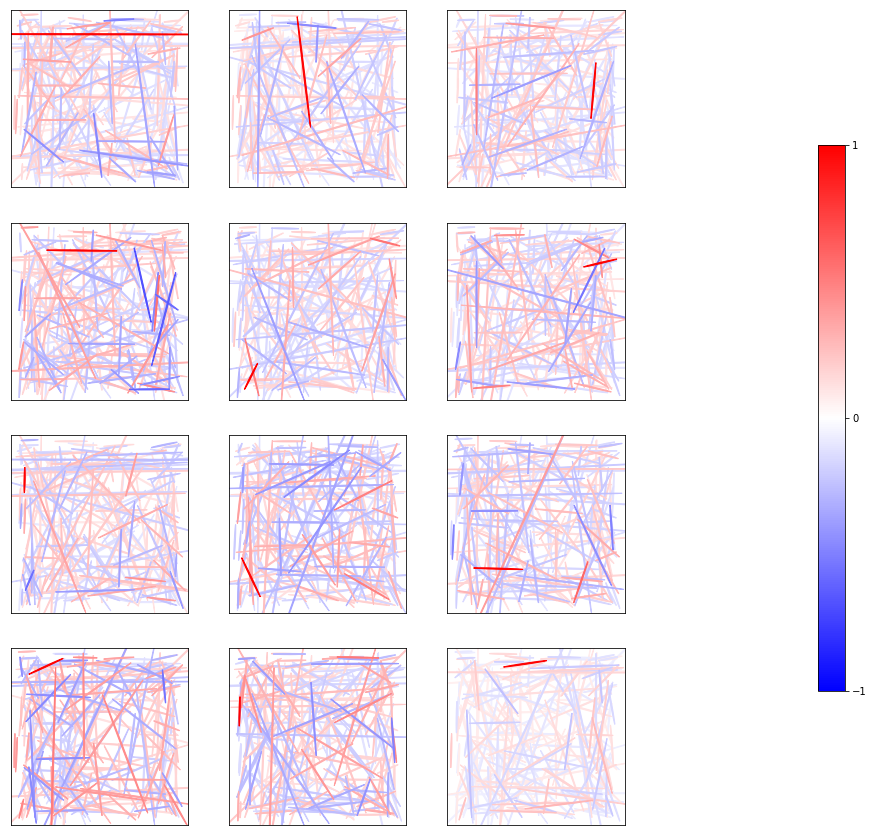

In [59]:
params["num_pooling_filters"] = 12
params["num_connected_weights"] = 250#75
lines = True
plot_pooling_summaries(bf_stats, pooling_filters, params["num_connected_weights"],
  params["num_pooling_filters"], lines)